In [ ]:
"""
Author: Alex Martin
Purpose: To approximate the ground state of the XX term of the hyperfine interaction using the VQE framework.
Date: Aug. 23, 2025

This code is utilized in "Studying the hyperfine interaction using the variational quantum eigensolver" by J. W. Martin and A. Martin.
"""

In [ ]:
!pip install qiskit
!pip install py-bobyqa
!pip install numpy
!pip install matplotlib
!pip install qiskit-ibm-runtime

!pip install pylatexenc
!apt-get update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended # Run this to use latex in your colab environment.
!pip install scienceplots

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from typing import List, Tuple, Callable
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(token="<replace with your token>",
                               channel="<enter channel here>",
                               instance="<replace with your instance>")

QPUs = service.backends()
print(QPUs) # Prints a list of QPUs to choose from.

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from collections import Counter
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Pauli
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit import transpile
from qiskit.circuit import Parameter
import pybobyqa

XX_history = [] # Initialize an empty list to store expectation values

shots = 2048 #1024 is default

hamiltonian = SparsePauliOp.from_list([("XX", 1.0)]) # Define Hamiltonian. This is only the X\otimes X term of the hyperfine interaction Hamiltonian.

backend = service.backend("ibm_brisbane") # You can choose whatever backend you want.

estimator = Estimator(backend)
estimator.options.default_shots = shots
estimator.options.resilience_level = 2 # Level 2 resilience applies dynamical decoupling and twirled readout error extinction.

theta = Parameter("theta")  # Define theta as a Parameter

# Create the quantum circuit with parameter theta. This is the general ansatz with hadamard applied to both qubits to transform to the computational basis before measurement.
XX = QuantumCircuit(2)
XX.h(0)
XX.cx(0, 1)
XX.x(0)
XX.p(theta, 1)
XX.h(0)
XX.h(1)


pm = generate_preset_pass_manager(backend=backend, optimization_level=3) # Defines a pass manager for circuit transpilation.
isa_XX = pm.run(XX) # Transpiles the XX circuit to match the instruction set architecture (ISA) of the chosen QPU.
isa_ham = hamiltonian.apply_layout(isa_XX.layout) # Applies the ISA circuit layout to the Hamiltonian.

def objective_function_XX(theta_XX):
    """Objective function for X tensor X."""

    job = estimator.run([(isa_XX, isa_ham, [theta_XX])]) # Creates a job using the primitive unified blocs (PUBs) from above.

    cost_XX = job.result()[0] # Stores the first indexed result from running the job
    XX_history.append(cost_XX) # Appends the expectation value to the XX_history list
    iteration = len(XX_history)

    print(f"Iteration: {iteration}, Exp. Val = {cost_XX.data.evs}, Theta = {theta_XX}")
    return cost_XX.data.evs[0]


rng = np.random.default_rng() # Random number generator
initial_theta = rng.random()  # Generates a float
print(f"\nInitial Theta = {initial_theta},")

# Perform the optimization:
XX_minimum = pybobyqa.solve(
    objective_function_XX,
    [initial_theta], # initial guess, needs to be a list for py-bobyqa
    objfun_has_noise=True,
    maxfun = 100 # Set this according to the problem
)

print(XX_minimum)

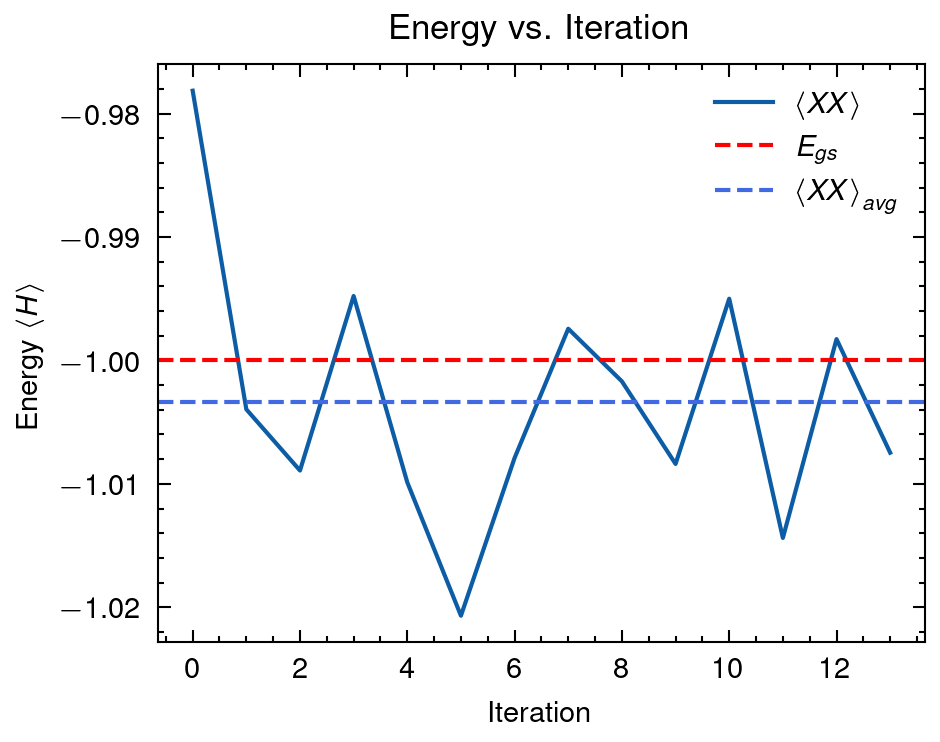

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
import os

plt.style.use(['science', 'nature']) #  https://github.com/garrettj403/SciencePlots.git
plt.rcParams['figure.dpi'] = 300

XX_history_values = [x.data.evs[0] for x in XX_history]  # Extract expectation values from XX_history

plt.plot(range(len(XX_history_values)), XX_history_values, label='${\langle XX\\rangle}$')

plt.xlabel('Iteration')
plt.ylabel("Energy $\langle H\\rangle$")
plt.title('Energy vs. Iteration')
plt.axhline(y=-1.0, color='r', linestyle='--', label="${E}_{{gs}}$")

avg = sum(XX_history_values) / len(XX_history_values)
plt.axhline(y=avg, color='royalblue', linestyle='--', label='${\langle XX\\rangle}_{avg}$')

plt.legend()

if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig(f'plots/XX.svg', format='svg')
plt.show()

In [ ]:
print(avg)

-1.0033515906397203
